In [2]:
import torch
import torch.nn as nn #related to neural networks
import torch.optim as optim #optimizer
from torch.utils.data import DataLoader, Dataset
import torchvision
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms, models
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
import sys
import timm
import tqdm
from PIL import Image
import json
from pycocotools.coco import COCO

import matplotlib.patches as patches
import cv2


In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


In [3]:
import yaml
def get_labels(yaml_file_path):
    with open(yaml_file_path, "r") as file:
        yaml_content = yaml.safe_load(file)
    return yaml_content.get("names", [])

In [4]:
with open("annotations.json", "r") as file:
    coco_data = json.load(file)
coco = COCO("annotations.json")
print(f"Number of images: {len(coco_data['images'])}")
print(f"Number of annotations: {len(coco_data['annotations'])}")
print(f"Number of categories: {len(coco_data['categories'])}")

x = 150
# Load a specific image by ID
image = coco.loadImgs(x)[0]
print(f"Image: {image}")

annotations = coco.loadAnns(coco.getAnnIds(imgIds=x))
print(annotations)
bounding_boxes = [ann['bbox'] for ann in annotations]
print(bounding_boxes)
label = coco.loadCats([annotations[0]['category_id']][0])[0]['name']
print(f"Label: {label}")

# Load the image
image_path = "images/" + image['file_name']
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

# Add bounding boxes
for ann in annotations:
    bbox = ann['bbox']  # [x, y, width, height]
    rect = patches.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2],
        bbox[3],
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images: 160
Number of annotations: 201
Number of categories: 40
Image: {'file_name': 'Screenshot 2024-10-11 174314.png', 'height': 804, 'width': 811, 'id': 150}
[{'id': 191, 'image_id': 150, 'category_id': 38, 'area': 112050.0, 'iscrowd': 0, 'segmentation': [[92, 305, 507, 305, 507, 575, 92, 575]], 'bbox': [92, 305, 415, 270]}]
[[92, 305, 415, 270]]
Label: WAVETRAP_NOPOT


[ WARN:0@0.074] global loadsave.cpp:268 findDecoder imread_('images/Screenshot 2024-10-11 174314.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# Create Circuit Diagram Dataset

In [5]:
class CircuitDiagramDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.ann_dir = os.path.join('annotations.json')
        self.image_dir = image_path
        self.transform = transform        
        self.coco = COCO("annotations.json")
    
    def __len__(self):
        return len(self.coco.getImgIds())
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.coco.loadImgs(idx)[0]['file_name'])
        
        # Load the image using PIL
        image = Image.open(img_path).convert("RGB")
        image_id = self.coco.loadImgs(idx)[0]['id']
        
        # Get annotation IDs for the image
        ann_ids = self.coco.getAnnIds(imgIds=idx)
        annotations = self.coco.loadAnns(ann_ids)
        
        # Prepare the annotations (usually bounding boxes and category labels)
        boxes = []
        labels = []
        for ann in annotations:
            bbox = ann['bbox']  # [x, y, width, height]
            bbox[2] += bbox[0]  # x + width
            bbox[3] += bbox[1]  # y + height
            category_id = ann['category_id']
            boxes.append(bbox)
            labels.append(category_id)
        
        # Convert boxes and labels to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Apply the transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        original_width, original_height = self.coco.loadImgs(idx)[0]['width'], self.coco.loadImgs(idx)[0]['height']
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        for i in range(len(boxes)):
            boxes[i][0] *= scale_x  # x
            boxes[i][1] *= scale_y  # y
            boxes[i][2] *= scale_x  # width
            boxes[i][3] *= scale_y  # height
        
        # Create a target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id])
        }
        
        # Return the image along with the bounding boxes and labels
        return image, target
    
    
    

In [6]:
def plot_image_with_boxes(image, boxes):
    # Convert image tensor to a numpy array (from [C, H, W] to [H, W, C] and denormalize if necessary)
    image = image.permute(1, 2, 0).numpy()
    image = (image * 255).astype("uint8")  # Denormalize if the image was normalized earlier
    
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(10, 8))
    
    # Display the image
    ax.imshow(image)
    
    # Add bounding boxes
    for box in boxes:
        xmin, ymin, xmax, ymax = map(int, box)
        rect = patches.Rectangle(
            (xmin, ymin),  # Starting point (x, y)
            xmax - xmin,   # Width
            ymax - ymin,   # Height
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
    
    # Show the plot
    plt.show()
    

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Image directory: 160
Image shape: torch.Size([3, 224, 224])
Boxes: tensor([[104.1983,  84.8900, 119.2727,  99.1296]])
Labels: CAP


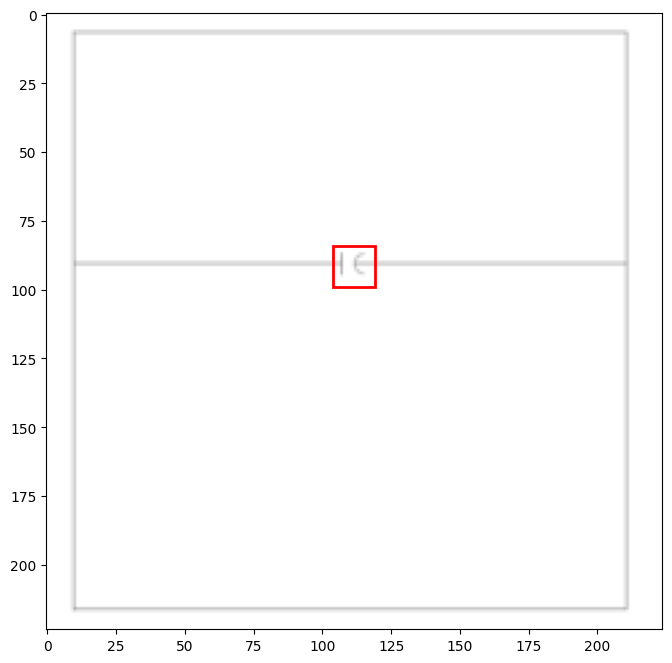

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test = CircuitDiagramDataset(    
    image_path="images",
    transform=transform)

image, target = test[41]
boxes = target["boxes"]
labels = target["labels"]
print(f"Image directory: {len(test.coco.getImgIds())}")
print(f"Image shape: {image.shape}")
print(f"Boxes: {boxes}")    
print(f"Labels: {test.coco.loadCats(labels.numpy())[0]['name']}")
plot_image_with_boxes(image, boxes)

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train = CircuitDiagramDataset(    
    image_path="images",
    transform=transform)

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

train_dataloader = DataLoader(train, batch_size=4, shuffle=True, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Defining Model

In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes=40):
    # Where we define all the parts of the model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [10]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# Training

In [5]:
model = get_model(num_classes=41)
model.to(device)
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0.0

    for images, targets in tqdm.tqdm(data_loader, desc=f"Epoch {epoch}"):
        # Ensure valid images and targets
        valid_samples = []
        for image, target in zip(images, targets):
            if target["image_id"].item() == 0:  # Skip image_id=0
                continue
            valid_samples.append((image, target))

        # Skip if no valid samples
        if not valid_samples:
            continue

        # Separate valid images and targets
        images = [sample[0].to(device) for sample in valid_samples]
        targets = [{k: v.to(device) for k, v in sample[1].items()} for sample in valid_samples]

        try:
            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass and optimization
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()

        except Exception as e:
            print(f"Error in processing batch: {e}")
            continue

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")

# Define optimizer and learning rate scheduler
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model for a few epochs
num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_dataloader, device, epoch)
    lr_scheduler.step()

NameError: name 'get_model' is not defined

In [1]:
from ultralytics import YOLO

# Load a pre-trained YOLO model
model = YOLO("yolo11n.pt")  # Use 'yolov8s', 'yolov8m', etc., for larger models

# Train the model
results = model.train(data="./data.yaml", epochs=5, device="mps")


metrics = model.val()
print(metrics.box.map)  # Check mAP score
results = model("images/train/Screenshot 2024-10-09 215306.png", conf=0.1)  # Inference on a single image
results.show()

New https://pypi.org/project/ultralytics/8.3.69 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.23 🚀 Python-3.12.6 torch-2.5.1 MPS (Apple M2)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=./data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

train: Scanning /Users/enerinn/Developer/CS25-338-main/Model/labels/train.cache... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]
val: Scanning /Users/enerinn/Developer/CS25-338-main/Model/labels/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]


Plotting labels to /Users/enerinn/Developer/CS25-338-main/runs/detect/train13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000227, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/enerinn/Developer/CS25-338-main/runs/detect/train13
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      4.59G      2.495      6.299      1.735         27        640: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      4.58G      2.089       5.96      1.572         35        640: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      4.57G      1.823      5.588      1.458         31        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40       4.6G      1.665      5.449      1.345         28        640: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      4.62G      1.487      5.092      1.195         38        640: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      4.61G      1.471      4.921      1.182         53        640: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         40         56          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      4.64G      1.364      4.809       1.15         35        640: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]

                   all         40         56       0.01      0.113     0.0305     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      4.65G      1.345      4.545      1.161         24        640: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]

                   all         40         56     0.0255      0.283     0.0576     0.0385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      4.66G       1.34      4.543      1.145         21        640: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.01s/it]

                   all         40         56     0.0151      0.308      0.105     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      4.66G      1.297      4.477      1.165         26        640: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.34s/it]

                   all         40         56     0.0428       0.56       0.22      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      4.69G      1.432      4.406        1.2         31        640: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.25s/it]

                   all         40         56     0.0347      0.619       0.24       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      4.71G      1.299       4.15      1.157         39        640: 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]

                   all         40         56      0.908     0.0964      0.241      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      4.72G      1.294      4.116       1.12         35        640: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.29s/it]

                   all         40         56      0.767      0.108      0.233      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      4.75G      1.279      4.069      1.139         32        640: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.54s/it]

                   all         40         56      0.625       0.17      0.282      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      4.74G      1.275      3.879       1.12         38        640: 100%|██████████| 10/10 [00:27<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.62s/it]

                   all         40         56      0.737      0.174      0.329      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      4.77G      1.178      3.868      1.115         28        640: 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.32s/it]

                   all         40         56      0.732      0.245      0.316      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      4.79G      1.219      3.988      1.136         29        640: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.11s/it]

                   all         40         56      0.765      0.302      0.378       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40       4.8G      1.272      3.809      1.125         29        640: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.54s/it]

                   all         40         56      0.702      0.321      0.383      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      4.84G       1.19      3.699      1.132         32        640: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.26s/it]

                   all         40         56      0.704      0.324      0.361      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      4.85G       1.26      3.741      1.166         27        640: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.42s/it]

                   all         40         56        0.6      0.336      0.348      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      4.86G      1.216      3.526      1.118         45        640: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.57s/it]

                   all         40         56      0.558      0.372      0.363      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      4.89G      1.228      3.502      1.137         25        640: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.90s/it]

                   all         40         56      0.629      0.276      0.349      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40       4.9G      1.156      3.562      1.085         27        640: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.50s/it]

                   all         40         56      0.597      0.339      0.389      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      4.89G      1.163      3.505      1.095         19        640: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.53s/it]

                   all         40         56      0.693       0.33      0.365       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      4.91G       1.17      3.297      1.105         31        640: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.24s/it]

                   all         40         56      0.682      0.367      0.414      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      4.92G      1.176      3.509      1.129         23        640: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.91s/it]

                   all         40         56      0.701      0.381      0.438      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      4.95G      1.174      3.194      1.124         45        640: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.60s/it]

                   all         40         56       0.67      0.402      0.428      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      4.94G      1.121      3.242      1.113         31        640: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.02s/it]

                   all         40         56       0.59      0.421      0.493      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      4.95G      1.205      3.532      1.131         27        640: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.56s/it]

                   all         40         56      0.668      0.362      0.457      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      4.96G      1.108      3.147      1.103         36        640: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.01s/it]

                   all         40         56      0.782      0.381      0.483      0.386


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      4.98G      1.057       3.52      1.103         22        640: 100%|██████████| 10/10 [00:23<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]

                   all         40         56      0.802      0.411      0.495      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40         5G      1.047      3.446      1.034         23        640: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.73s/it]

                   all         40         56      0.809      0.294      0.362      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      5.03G      1.046       3.58      1.057         18        640: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.97s/it]

                   all         40         56      0.784      0.403      0.468      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      5.06G      1.007      3.412      1.019         18        640: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.52s/it]

                   all         40         56      0.842      0.398      0.467      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40       5.1G      1.013      3.351      1.061         18        640: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.85s/it]

                   all         40         56       0.83      0.407      0.455      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      5.12G     0.9987      3.179      1.046         20        640: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.90s/it]

                   all         40         56      0.825      0.392      0.482      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      5.12G      1.022      3.323       1.05         19        640: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.19s/it]

                   all         40         56      0.855      0.366      0.441      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      5.13G     0.9773      3.288      1.063         16        640: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.01s/it]

                   all         40         56      0.823      0.403      0.521      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      5.14G      1.016      3.304      1.048         24        640: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]

                   all         40         56      0.826      0.421      0.532      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      5.17G     0.9873      3.355       1.03         16        640: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]

                   all         40         56      0.837      0.408      0.485       0.39



40 epochs completed in 0.297 hours.
Optimizer stripped from /Users/enerinn/Developer/CS25-338-main/runs/detect/train13/weights/last.pt, 5.5MB
Optimizer stripped from /Users/enerinn/Developer/CS25-338-main/runs/detect/train13/weights/best.pt, 5.5MB

Validating /Users/enerinn/Developer/CS25-338-main/runs/detect/train13/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.12.6 torch-2.5.1 MPS (Apple M2)
YOLO11n summary (fused): 238 layers, 2,589,952 parameters, 0 gradients, 6.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:19<00:00,  9.68s/it]


                   all         40         56      0.822       0.41      0.531      0.431
                  25FP          1          2          1      0.756      0.995      0.722
                  30FP          1          3      0.858          1      0.995      0.698
                  35FP          1          3      0.811          1      0.995      0.781
            38BRKR_ATT          1          2      0.715          1      0.995      0.895
                  40FP          1          4      0.423       0.75      0.538      0.406
                  45FP          1          3      0.804          1      0.995      0.886
                50FPUP          1          1          1          0          0          0
                 Arrow          1          1          1          0          0          0
              AUTOXFMR          1          1          1          0          0          0
              BRKR_ATT          1          1          1          0          0          0
                   CA

val: Scanning /Users/enerinn/Developer/CS25-338-main/Model/labels/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.50s/it]


                   all         40         56      0.749      0.498      0.651      0.523
                  25FP          1          2          1      0.792      0.995      0.721
                  30FP          1          3      0.817          1      0.995       0.73
                  35FP          1          3      0.804          1      0.995      0.764
            38BRKR_ATT          1          2       0.55          1      0.995      0.895
                  40FP          1          4      0.317       0.75      0.518      0.405
                  45FP          1          3      0.552          1       0.83      0.748
                50FPUP          1          1          1          0      0.497      0.398
                 Arrow          1          1          1          0      0.995      0.597
              AUTOXFMR          1          1      0.454          1      0.995      0.895
              BRKR_ATT          1          1          1          0      0.142     0.0995
                   CA

AttributeError: 'list' object has no attribute 'show'